# A Combined Problem

> This page is a Jupyter Notebook that can be [found and downloaded at the GitHub repository](https://github.com/trchudley/geospatial-python-durham/blob/main/website/02_using/03d_combined.ipynb).

What I haven't mentioned yet is that we can put it all together to do some more advanced analysis!

In [11]:
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import numpy as np
import matplotlib.pyplot as plt

Lets get back our North America climate data from section 2.

In [12]:
xds = xr.tutorial.load_dataset("air_temperature")

As discussed, we can easily extract data at a single point:

In [13]:
chicago_lat = 41.8781
chicago_lon = -87.6298 + 360 # data is in positive degrees east, so add 360
ts_chicago = xds['air'].sel(lat=chicago_lat, lon=chicago_lon, method="nearest")
ts_chicago = ts_chicago - 273.15

However, what if we're interested not in a single point but in a broad region? For instance, Ohio:

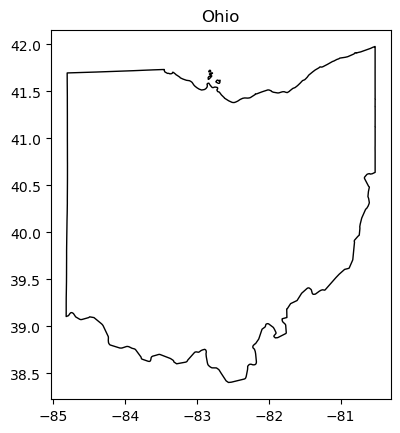

In [14]:
ohio_gdf = gpd.read_file('https://raw.githubusercontent.com/glynnbird/usstatesgeojson/refs/heads/master/ohio.geojson')

fig, ax = plt.subplots()
ohio_gdf.plot(ax=ax, fc='none', ec='black')
ax.set_title('Ohio')
plt.show()

## Adding `rioxarray` metadata to an `xarray` dataset

In section 1, we showed how we can clip one geopandas dataframe with another. Can we do this to our climate dataset? Yes! Via `rioxarray`. 

First, we need to make sure our xarray climate dataset has a rioxarray-compatible `spatial_ref`. Our `xarray` dataset already has lat/lon data, so it should be as simple as telling `rioxarray` that this is in EPSG:4326.

In [15]:
xds_referenced = xds.rio.write_crs('EPSG:4326')

Now, we should be able to plot them over the top!

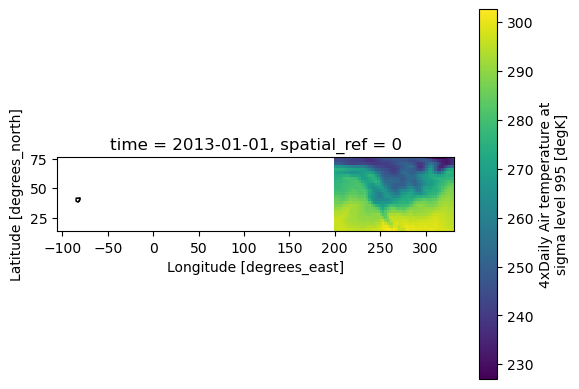

In [16]:
fig, ax = plt.subplots()
xds_referenced.isel(time=0).air.plot.imshow(ax=ax)
ohio_gdf.plot(ax=ax, fc='none', ec='black')
plt.show()

Oh dear. 95% of the time this will work without worries, but something has gone wrong here. Luckily, we can easily diagnose this problem. 

## Using LLMs to solve problems

Well, it's relatively easy to diagnose what has happened. Ohio is appearing in negative longitude (as we would expect), whilst the climate data is appearing at longitudes > 180˚. The climate data has the annoying coordinates 'degrees east', meaning that the western hemisphere is between 180 and 360. This is probably to avoid messing up some climate model somewhere that doesn't do proper coordiante systems. `xarray` was primarily motivated to host large climate datasets, by people who weren't necessarily motivated by proper spatial metadata - this is why `rioxarray` exists on top of `xarray`!

How do I fix this? I have some ideas, but this is the sort of thing that LLMs are useful for, so long as we construct our question appropriately. I asked the following: 

> I am using Python and `xarray` and have a problem. I have an xarray climate dataset with `lat` and `lon` coordinates that I would like to assign a `rioxarray` CRS to. However, the climate longitude data is in "degrees east", so my data, which is of North America, has the range 200-320 (degrees east). I wish to clip this with a geopandas dataframe which has a 'normal' EPSG:3413 projection, so longidues of ~-80. How can I fix this?

Note this quite specific: I told the LLM what tools I am using, what the problem is, what the variable names are, and what I think is wrong. As a result, it gave me back a solution that worked first time (if it doesn't, you can always feed it an error message and it may be able to resolve the problem). It is always better to know what you are doing when you are using LLMs: if you can't ask good questions, you won't get good results and you won't be able to critically assess what you get in return.

Anyway, this is the solution I received:


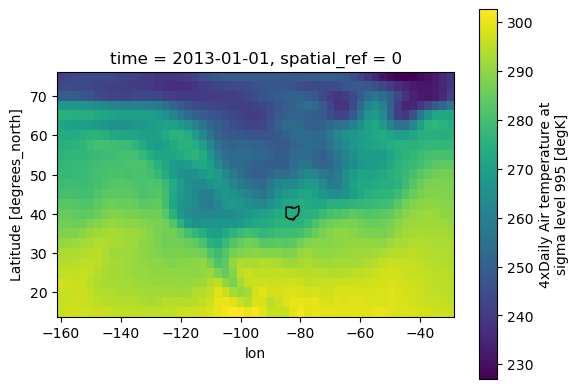

In [17]:
# convert longitudes
lon = xds_referenced['lon']
lon_180 = ((lon + 180) % 360) - 180   # wrap to [-180, 180)

# Note - you can't just do:
#   xds_referenced['lon'] = xds_referenced['lon'] + 180
# as coordinate data are 'immutable' - they can't be altered in-place

# assign new longitude coordinate
xds_referenced = xds_referenced.assign_coords(lon=lon_180)

# set the spatial dimensions explicitly
xds_referenced = xds_referenced.rio.set_spatial_dims(x_dim="lon", y_dim="lat")

# write the crs again
xds_referenced = xds_referenced.rio.write_crs('EPSG:4326')

# plot
fig, ax = plt.subplots()
xds_referenced.isel(time=0).air.plot.imshow(ax=ax)
ohio_gdf.plot(ax=ax, fc='none', ec='black')
plt.show()

Great, fixed! The dataset is now `rioxarray`-compatible, and we can apply the `.rio` accessor to the dataset: specifically, `.rio.clip()`:

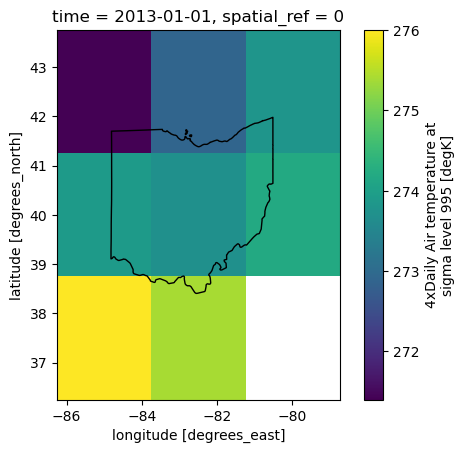

In [18]:
# Clip to ohio_gdf
xds_ohio = xds_referenced.rio.clip(ohio_gdf.geometry.values, all_touched=True)

# plot
fig, ax = plt.subplots()
xds_ohio.isel(time=0).air.plot.imshow(ax=ax)
ohio_gdf.plot(ax=ax, fc='none', ec='black')
plt.show()

Great stuff. Note that I have included the parameter `all_touched=True`. This is because our pixel sizes are large relative to our AOI, and by default the clip removes all pixels than touch the boundary. If we did that, there would be no pixels left! Instead, let's calculate the mean temperature over Ohio from the eight pixels the state touches, and plot it accordingly against our data from Chicago earlier.

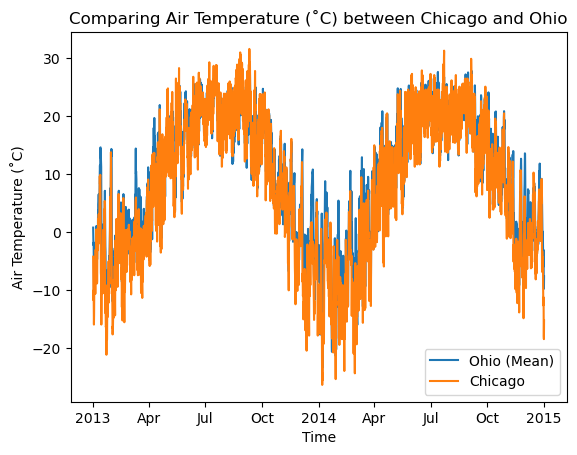

In [19]:
# Calculate the mean, compressing spatial dimensions and leaving only time
ts_ohio = xds_ohio.air.mean(dim=['lat', 'lon'])

# Convert to celcius
ts_ohio -= 273.15

# Plot
fig, ax = plt.subplots()

ts_ohio.plot(ax=ax, label='Ohio (Mean)')
ts_chicago.plot(ax=ax, label='Chicago')

ax.set_xlabel('Time')
ax.set_ylabel('Air Temperature (˚C)')
ax.legend()

ax.set_title('Comparing Air Temperature (˚C) between Chicago and Ohio')
plt.show()


I hope you can see how we can use tools such as `geopandas`, `xarray`, and `rioxarray` in powerful ways to perform geospatial analysis.